In [11]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import deepdish as dd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Input, Activation, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
#define parameters 
file_path_dataset = "/Users/sanchit/Documents/Projects/datasets/audio_data/speech_commands/audio_cleaned_dataset.h5"
batch_size = 64 
epochs = 20

In [3]:
def load_data(file_path="", class_mode="binary"):
    X = []
    y = []
    dataset = dd.io.load(file_path)
    
    # create class name to a label index map 
    list_classes = dataset.keys() 
    list_classes = sorted(list_classes)

    class_to_index = dict()
    for ind, class_name in enumerate(list_classes):
        class_to_index[class_name] = ind
        
    for class_name, list_feats in dataset.items():
        print(f"loading data for class: {class_name}")
        for feat in list_feats:
            data = img_to_array(feat)
            X.append(data)
            y.append(class_to_index[class_name])
        
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y)
    
    if class_mode == "categorical":
        y = to_categorical(y)
        
    return X, y, class_to_index

In [4]:
def build_model(width, height, num_classes):
    """Build 2D CNN classifier."""
    input_data = Input(shape=(width, height, 1), name="input_layer")
    
    x = BatchNormalization(center=True, scale=True)(input_data) # normalize and scale the data first 
    x = Conv2D(16, kernel_size=(3, 7), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(16, kernel_size=(7, 3), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(32, kernel_size=(3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(64, kernel_size=(3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = GlobalAveragePooling2D()(x)
    
    # classifier 
    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)
    
    output = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=input_data, outputs=output)
    
    return model

In [5]:
# load the whole data 
X, y, class_to_ind_map = load_data(file_path=file_path_dataset, class_mode="categorical")
num_classes = len(class_to_ind_map)

/anaconda3/envs/tf2.0_mkl/lib/python3.6/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


loading data for class: background
loading data for class: down
loading data for class: go
loading data for class: left
loading data for class: no
loading data for class: off
loading data for class: on
loading data for class: right
loading data for class: stop
loading data for class: up
loading data for class: yes


In [6]:
# split the dataset into training and validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
nb_train_samples = len(X_train)
nb_test_samples = len(X_test)

In [7]:
# create train and test generators 
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator() 

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

In [8]:
# get the model and compile it 
model = build_model(128, 44, num_classes)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 128, 44, 1)]      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 44, 1)        4         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 44, 16)       352       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 44, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 128, 44, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 44, 16)       5392      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 44, 16)       64    

In [9]:
# train the model     
H = model.fit_generator(train_generator, 
                        steps_per_epoch=nb_train_samples // batch_size, 
                        epochs=epochs, 
                        validation_data=test_generator, 
                        validation_steps=nb_test_samples // batch_size, 
                        workers = 6, 
                        use_multiprocessing=True)

Epoch 1/20
294/294 [==============================] - 339s 1s/step - loss: 1.9092 - accuracy: 0.3230 - val_loss: 2.5206 - val_accuracy: 0.1796
Epoch 2/20
294/294 [==============================] - 324s 1s/step - loss: 1.3427 - accuracy: 0.5514 - val_loss: 2.4381 - val_accuracy: 0.2898
Epoch 3/20
294/294 [==============================] - 315s 1s/step - loss: 1.0164 - accuracy: 0.6712 - val_loss: 1.9943 - val_accuracy: 0.4238
Epoch 4/20
294/294 [==============================] - 317s 1s/step - loss: 0.7965 - accuracy: 0.7464 - val_loss: 1.2797 - val_accuracy: 0.6017
Epoch 5/20
294/294 [==============================] - 340s 1s/step - loss: 0.6620 - accuracy: 0.7914 - val_loss: 1.6063 - val_accuracy: 0.4949
Epoch 6/20
294/294 [==============================] - 337s 1s/step - loss: 0.5761 - accuracy: 0.8197 - val_loss: 1.4649 - val_accuracy: 0.5839
Epoch 7/20
294/294 [==============================] - 329s 1s/step - loss: 0.5163 - accuracy: 0.8374 - val_loss: 0.9988 - val_accuracy: 0.6625

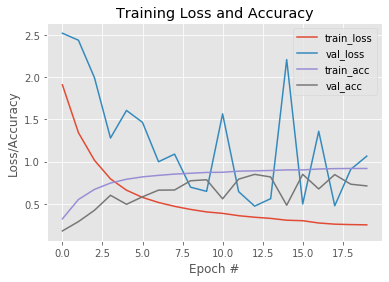

In [14]:
# plot train/val losses
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()